# Selection on Observables 

## Purpose 

Narrative about the purpose and structure of this public notebook to go here

# Import Needed Libraries 

In [7]:
# Built-in libraries
import sys

# Third party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import copy
from causalgraphicalmodels import CausalGraphicalModel
from collections import defaultdict, OrderedDict
import pylogit as pl

# Local libraries
sys.path.insert(0, '../../')
import src.observables.distfit as distfit
import src.observables.simulation as sim
import src.observables.regression as reg
import src.observables.availability as av
from src.viz.predictive_viz import simulate_choice_vector

# Set Notebook Parameters

In [8]:
# Path to Data
DATA_PATH = '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [9]:
# Definition of causal graphs nodes and edges

# Independent
NODES_IND = ["Total Travel Distance",
             "Total Travel Time",
             "Total Travel Cost",
             "Number of Licensed Drivers",
             "Number of Autos",
             "Utility (Drive Alone)"]

EDGES_IND = [("Total Travel Distance", "Utility (Drive Alone)"),
             ("Total Travel Time", "Utility (Drive Alone)"),
             ("Total Travel Cost", "Utility (Drive Alone)"),
             ("Number of Licensed Drivers", "Utility (Drive Alone)"),
             ("Number of Autos", "Utility (Drive Alone)")]
# Drive Alone
NODES_DA = ["Total Travel Distance",
            "Total Travel Time",
            "Total Travel Cost",
            "Number of Autos",
            "Number of Licensed Drivers",
            "Utility (Drive Alone)"]

EDGES_DA = [("Total Travel Distance", "Total Travel Time"),
            ("Total Travel Distance", "Total Travel Cost"),
            ("Total Travel Distance", "Utility (Drive Alone)"),
            ("Total Travel Time", "Utility (Drive Alone)"),
            ("Total Travel Cost", "Utility (Drive Alone)"),
            ("Number of Autos", "Utility (Drive Alone)"),
            ("Number of Licensed Drivers", "Utility (Drive Alone)")]

# Shared-2
NODES_SHARED_2 = ["Total Travel Time",
                  "Total Travel Distance",
                  "Total Travel Cost",
                  "Cross Bay Trip",
                  "Number of Autos",
                  "Number of Licensed Drivers",
                  "Household Size",
                  "Number of Kids",
                  "Utility (Shared Ride 2)"]

EDGES_SHARED_2 = [("Total Travel Distance", "Total Travel Time"),
                  ("Total Travel Distance", "Total Travel Cost"),
                  ("Total Travel Distance", "Utility (Shared Ride 2)"),
                  ("Total Travel Time", "Utility (Shared Ride 2)"),
                  ("Number of Autos", "Utility (Shared Ride 2)"),
                  ("Number of Licensed Drivers", "Utility (Shared Ride 2)"),
                  ("Total Travel Cost", "Utility (Shared Ride 2)"),
                  ("Household Size", "Utility (Shared Ride 2)"),
                  ("Cross Bay Trip", "Utility (Shared Ride 2)"),
                  ("Number of Kids", "Utility (Shared Ride 2)")]

# Shared-3+
NODES_SHARED_3P = ["Total Travel Time",
                   "Total Travel Distance",
                   "Total Travel Cost",
                   "Cross Bay Trip",
                   "Number of Autos",
                   "Number of Licensed Drivers",
                   "Household Size",
                   "Number of Kids",
                   "Utility (Shared Ride 3+)"]

EDGES_SHARED_3P = [("Total Travel Distance", "Total Travel Time"),
                   ("Total Travel Distance", "Total Travel Cost"),
                   ("Total Travel Distance", "Utility (Shared Ride 3+)"),
                   ("Total Travel Time", "Utility (Shared Ride 3+)"),
                   ("Number of Autos", "Utility (Shared Ride 3+)"),
                   ("Number of Licensed Drivers", "Utility (Shared Ride 3+)"),
                   ("Total Travel Cost", "Utility (Shared Ride 3+)"),
                   ("Household Size", "Utility (Shared Ride 3+)"),
                   ("Cross Bay Trip", "Utility (Shared Ride 3+)"),
                   ("Number of Kids", "Utility (Shared Ride 3+)")]

# Walk-Transit-Walk
NODES_WTW = ["Total Travel Time",
             "Total Travel Cost",
             "Utility (WTW)"]

EDGES_WTW = [("Total Travel Time", "Total Travel Cost"),
             ("Total Travel Time", "Utility (WTW)"),
             ("Total Travel Cost", "Utility (WTW)")]

# Drive-Transit-Walk
NODES_DTW = ["Total Travel Time",
             "Total Travel Cost",
             "Utility (DTW)"]

EDGES_DTW = [("Total Travel Time", "Total Travel Cost"),
             ("Total Travel Time", "Utility (DTW)"),
             ("Total Travel Cost", "Utility (DTW)")]

# Walk-Transit-Drive
NODES_WTD = ["Total Travel Time",
             "Total Travel Cost",
             "Utility (WTD)"]

EDGES_WTD = [("Total Travel Time", "Total Travel Cost"),
             ("Total Travel Time", "Utility (WTD)"),
             ("Total Travel Cost", "Utility (WTD)")]

# Walk
NODES_WALK = ["Total Travel Distance",
              "Utility (Walk)"]

EDGES_WALK = [("Total Travel Distance", "Utility (Walk)")]

# Bike
NODES_BIKE = ["Total Travel Distance",
              "Utility (Bike)"]
EDGES_BIKE = [("Total Travel Distance", "Utility (Bike)")]

In [10]:
# Alternative id column from long format data
ALT_ID_COL = 'mode_id'

# Individual specific variables list
IND_SPEC_VARS = ['household_size', 'num_kids',
                 'num_cars', 'num_licensed_drivers']

# Alternative specific variables dictionary
# Key is alternative number, value is a list
# of alternative specific nodes without parents
ALT_SPEC_DICT = {1: ['total_travel_distance'],
                 2: ['total_travel_distance'],
                 3: ['total_travel_distance'],
                 4: ['total_travel_time'],
                 5: ['total_travel_time'],
                 6: ['total_travel_time'],
                 7: ['total_travel_distance'],
                 8: ['total_travel_distance']}

# Trip specific variables list
TRIP_SPEC_VARS = ['cross_bay']

# Alternative name dictionary
# Key is alternative number
# value is alternative number snake cased
ALT_NAME_DICT = {1: 'drive_alone',
                 2: 'shared_2',
                 3: 'shared_3p',
                 4: 'wtw',
                 5: 'dtw',
                 6: 'wtd',
                 7: 'walk',
                 8: 'bike'}

ALT_ID_TO_MODE_NAME = {1: "Drive Alone",
                       2: "Shared Ride 2",
                       3: "Shared Ride 3+",
                       4: "Walk-Transit-Walk",
                       5: "Drive-Transit-Walk",
                       6: "Walk-Transit-Drive",
                       7: "Walk",
                       8: "Bike"}

# Variable type Dictionary
# Key is string with variable name from previous
# dictionaries and lists, value is a string
# with type of the variable
VARS_TYPE = {'num_kids': 'categorical',
             'household_size': 'categorical',
             'num_cars': 'categorical',
             'num_licensed_drivers': 'categorical',
             'cross_bay': 'categorical',
             'total_travel_time': 'continuous',
             'total_travel_distance': 'continuous',
             'total_travel_cost': 'continuous'}

# Distribution to be explored for continuous variables
CONT_DISTS = ['norm', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']

In [11]:
# Declare regression parameters

REGS_DA = {1: ('total_travel_distance', 'total_travel_cost'),
           2: ('total_travel_distance', 'total_travel_time')}

REGS_TYPE_DA = {1: 'linear',
                2: 'linear'}


REGS_SHARED_2 = {1: ('total_travel_distance', 'total_travel_cost'),
                 2: ('total_travel_distance', 'total_travel_time')}

REGS_TYPE_SHARED_2 = {1: 'linear',
                      2: 'linear'}


REGS_SHARED_3P = {1: ('total_travel_distance', 'total_travel_cost'),
                  2: ('total_travel_distance', 'total_travel_time')}

REGS_TYPE_SHARED_3P = {1: 'linear',
                       2: 'linear'}


REGS_WTW = {1: ('total_travel_time', 'total_travel_cost')}

REGS_TYPE_WTW = {1: 'linear'}


REGS_DTW = {1: ('total_travel_time', 'total_travel_cost')}

REGS_TYPE_DTW = {1: 'linear'}


REGS_WTD = {1: ('total_travel_time', 'total_travel_cost')}

REGS_TYPE_WTD = {1: 'linear'}

In [12]:
# Parameters for conversion from Wide to Long

IND_VARIABLES = ['num_kids', 'household_size',
                 'num_cars', 'num_licensed_drivers', 'cross_bay']


# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
ALT_VARYING_VARIABLES = {u'total_travel_time': dict([(1, 'total_travel_time_drive_alone'),
                                                     (2, 'total_travel_time_shared_2'),
                                                     (3, 'total_travel_time_shared_3p'),
                                                     (4, 'total_travel_time_wtw'),
                                                     (5, 'total_travel_time_dtw'),
                                                     (6, 'total_travel_time_wtd')]),
                         u'total_travel_cost': dict([(1, 'total_travel_cost_drive_alone'),
                                                     (2, 'total_travel_cost_shared_2'),
                                                     (3, 'total_travel_cost_shared_3p'),
                                                     (4, 'total_travel_cost_wtw'),
                                                     (5, 'total_travel_cost_dtw'),
                                                     (6, 'total_travel_cost_wtd')]),
                         u'total_travel_distance': dict([(1, 'total_travel_distance_drive_alone'),
                                                         (2, 'total_travel_distance_shared_2'),
                                                         (3, 'total_travel_distance_shared_3p'),
                                                         (7, 'total_travel_distance_walk'),
                                                         (8, 'total_travel_distance_bike')])}


# Dictionary of alternative availability variables
AVAILABILITY_VARIABLES = {1: 'drive_alone_AV',
                          2: 'shared_2_AV',
                          3: 'shared_3p_AV',
                          4: 'wtw_AV',
                          5: 'dtw_AV',
                          6: 'wtd_AV',
                          7: 'walk_AV',
                          8: 'bike_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
CUSTOM_ALT_ID = "mode_id"

OBS_ID_COL = "observation_id"

# Declare choice column
CHOICE_COL = "sim_choice"

In [13]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

MNL_SPECIFICATION = OrderedDict()
MNL_NAMES = OrderedDict()

MNL_SPECIFICATION["intercept"] = [2, 3, 4, 5, 6, 7, 8]
MNL_NAMES["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

MNL_SPECIFICATION["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
MNL_NAMES["total_travel_time"] = ['Travel Time, units:min (All Auto Modes)',
                                  'Travel Time, units:min (All Transit Modes)']

MNL_SPECIFICATION["total_travel_cost"] = [[4, 5, 6]]
MNL_NAMES["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

MNL_SPECIFICATION["cost_per_distance"] = [1, 2, 3]
MNL_NAMES["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-2)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

MNL_SPECIFICATION["cars_per_licensed_drivers"] = [[1, 2, 3]]
MNL_NAMES["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

MNL_SPECIFICATION["total_travel_distance"] = [7, 8]
MNL_NAMES["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

MNL_SPECIFICATION["cross_bay"] = [[2, 3]]
MNL_NAMES["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

MNL_SPECIFICATION["household_size"] = [[2, 3]]
MNL_NAMES["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

MNL_SPECIFICATION["num_kids"] = [[2, 3]]
MNL_NAMES["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

# Load and Describe Data 

In [14]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(DATA_PATH)

# Look at the mode shares in the data set

mode_counts = bike_data_long.loc[bike_data_long.choice == 1,
                                 "mode_id"].value_counts().loc[range(1, 9)]

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [ALT_ID_TO_MODE_NAME[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

# Choice Model Estimation 

In [15]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(data=bike_data_long,
                                   alt_id_col=ALT_ID_COL,
                                   obs_id_col=OBS_ID_COL,
                                   choice_col="choice",
                                   specification=MNL_SPECIFICATION,
                                   model_type="MNL",
                                   names=MNL_NAMES)

num_vars = len(reduce(lambda x, y: x + y, MNL_NAMES.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.17 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Sun, 21 Jun 2020   Pseudo R-squ.:                   0.332
Time:                             17:09:57   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

# Show Causal Graphs

## Independent Causal Graph 

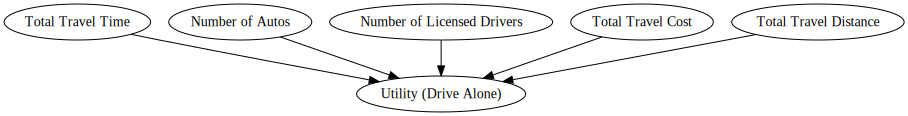

In [16]:
ind_graph = CausalGraphicalModel(NODES_IND, EDGES_IND)
ind_graph.draw()

## Drive Alone

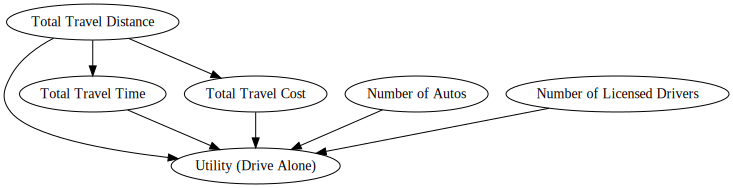

In [17]:
V_drive_alone = CausalGraphicalModel(NODES_DA, EDGES_DA)
V_drive_alone.draw()

## Shared-2

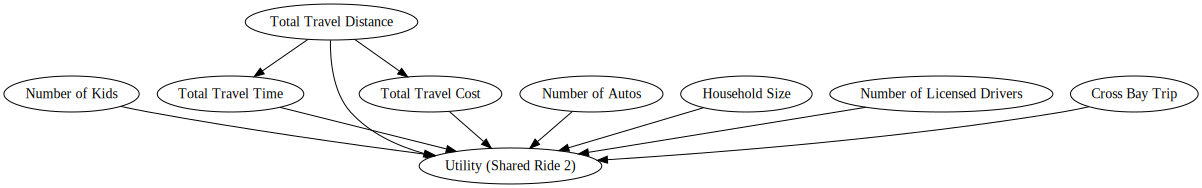

In [18]:
V_shared_2 = CausalGraphicalModel(NODES_SHARED_2, EDGES_SHARED_2)
V_shared_2.draw()

## Shared-3+

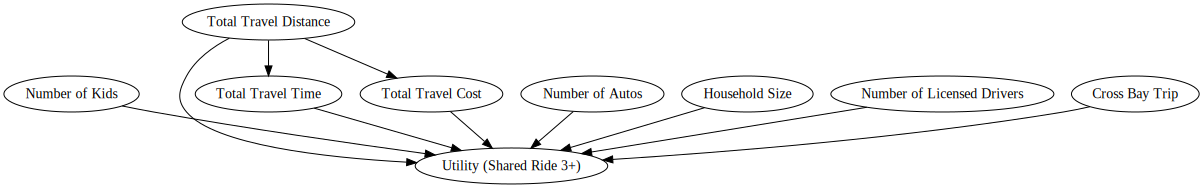

In [19]:
V_shared_3p = CausalGraphicalModel(NODES_SHARED_3P, EDGES_SHARED_3P)
V_shared_3p.draw()

## Walk-Transit-Walk

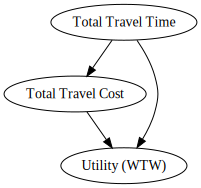

In [20]:
V_wtw = CausalGraphicalModel(NODES_WTW, EDGES_WTW)
V_wtw.draw()

## Drive-Transit-Walk

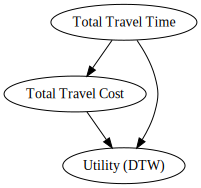

In [21]:
V_dtw = CausalGraphicalModel(NODES_DTW, EDGES_DTW)
V_dtw.draw()

##  Walk-Transit-Drive

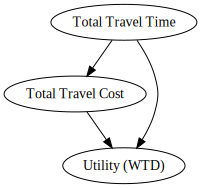

In [22]:
V_wtd = CausalGraphicalModel(NODES_WTD, EDGES_WTD)
V_wtd.draw()

## Walk

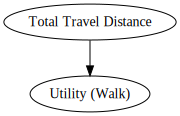

In [23]:
V_walk = CausalGraphicalModel(NODES_WALK, EDGES_WALK)
V_walk.draw()

## Bike 

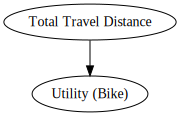

In [24]:
V_bike = CausalGraphicalModel(NODES_BIKE, EDGES_BIKE)
V_bike.draw()

# Selection on Observables Simulation

## Main Idea 

## Distribution Fitting 

In [25]:
bike_data_params = distfit.get_dist_node_no_parent(bike_data_long,
                                                   ALT_ID_COL,
                                                   OBS_ID_COL,
                                                   ALT_SPEC_DICT,
                                                   ALT_NAME_DICT,
                                                   IND_SPEC_VARS,
                                                   TRIP_SPEC_VARS,
                                                   VARS_TYPE,
                                                   CONT_DISTS)

Getting Distributions of Individual Specific Variables...
---------------------------------------------------------
Done...
Getting Distributions of Alternative Specific Variables...
----------------------------------------------------------
Fitted norm distribution with error=0.014164054487182288)
Fitted alpha distribution with error=0.014522128648725777)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.0011963782652540424)
Fitted gamma distribution with error=0.0011394543473683448)
Fitted expon distribution with error=0.002052652669300775)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.014136723006166226)
Fitted alpha distribution with error=0.014457810916552023)
Fitted beta distribution with error=0.0012976882508515305)
Fitted gamma distribution with error=0.0012552378475140624)
Fitted expon distribution with error=0.0019967778289294194)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.014117434128009247)
Fitted alpha distribution with error=0.014462601227138085)
Fitted beta distribution with error=0.001276124018206852)
Fitted gamma distribution with error=0.0012547975031013958)
Fitted expon distribution with error=0.0020004181046601524)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.0004036911862300816

## Regression Fitting 

## Drive Alone 

In [26]:
drive_alone_df = bike_data_long.loc[bike_data_long['mode_id'] == 1]

drive_alone_df.reset_index(drop=True, inplace=True)

fitted_reg_da = reg.fit_alternative_regression(regressions=REGS_DA, 
                                               reg_types=REGS_TYPE_DA,
                                               data=drive_alone_df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Shared-2

In [27]:
shared_2_df = bike_data_long.loc[bike_data_long['mode_id'] == 2]

shared_2_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_2 = reg.fit_alternative_regression(regressions=REGS_SHARED_2,
                                                     reg_types=REGS_TYPE_SHARED_2,
                                                     data=shared_2_df)

## Shared-3+

In [28]:
shared_3p_df = bike_data_long.loc[bike_data_long['mode_id'] == 3]

shared_3p_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_3p = reg.fit_alternative_regression(regressions=REGS_SHARED_3P,
                                                      reg_types=REGS_TYPE_SHARED_3P,
                                                      data=shared_3p_df)

## Walk-Transit-Walk 

In [29]:
wtw_df = bike_data_long.loc[bike_data_long['mode_id'] == 4]

wtw_df.reset_index(drop=True, inplace=True)

fitted_reg_wtw = reg.fit_alternative_regression(regressions=REGS_WTW,
                                                reg_types=REGS_TYPE_WTW,
                                                data=wtw_df)

## Drive-Transit-Walk 

In [30]:
dtw_df = bike_data_long.loc[bike_data_long['mode_id'] == 5]

dtw_df.reset_index(drop=True, inplace=True)

fitted_reg_dtw = reg.fit_alternative_regression(regressions=REGS_DTW,
                                                reg_types=REGS_TYPE_DTW,
                                                data=dtw_df)

## Walk-Transit-Drive

In [31]:
wtd_df = bike_data_long.loc[bike_data_long['mode_id'] == 6]

wtd_df.reset_index(drop=True, inplace=True)

fitted_reg_wtd = reg.fit_alternative_regression(regressions=REGS_WTD,
                                                reg_types=REGS_TYPE_WTD,
                                                data=wtd_df)

## Simulation

### Simulation Parameters

In [32]:
simulation_sizes = np.random.randint(low=3000, high=9000, size=2)
sim_number = np.arange(1, 3)
models_dictionary = defaultdict(dict)
causal_effect_dictionary = {}
perturb = 0.8
simulation_data = {}
causal_effects = pd.DataFrame(columns=['naive_effect', 'true_effect', 'estimated_effect'])

In [36]:
for sim_size, number in zip(simulation_sizes, sim_number):
    print('Simulation number', number, 'is in progress...')
    print('Simulation size is', sim_size)
    print('------------------------------------------')
    print('Simulating data...')
    # Simulate data without parents
    sim_bike_data_no_parent = sim.sim_node_no_parent(params_dict=bike_data_params,
                                                     size=sim_size)

    sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

    # Simulate nodes based on causal graphs
    # Drive Alone
    sim_bike_data_wide['total_travel_time_drive_alone'] =\
        reg.lin_reg_pred(X=sim_bike_data_wide['total_travel_distance_drive_alone'],
                         fitted_reg=fitted_reg_da['total_travel_time_on_total_travel_distance'],
                         size=sim_size)

    sim_bike_data_wide['total_travel_cost_drive_alone'] =\
        reg.lin_reg_pred(X=sim_bike_data_wide['total_travel_distance_drive_alone'],
                         fitted_reg=fitted_reg_da['total_travel_cost_on_total_travel_distance'],
                         size=sim_size)

    # Shared Ride 2
    sim_bike_data_wide['total_travel_time_shared_2'] =\
        reg.lin_reg_pred(X=sim_bike_data_wide['total_travel_distance_shared_2'],
                         fitted_reg=fitted_reg_shared_2['total_travel_time_on_total_travel_distance'],
                         size=sim_size)

    sim_bike_data_wide['total_travel_cost_shared_2'] =\
        reg.lin_reg_pred(X=sim_bike_data_wide['total_travel_distance_shared_2'],
                         fitted_reg=fitted_reg_shared_2['total_travel_cost_on_total_travel_distance'],
                         size=sim_size)

    # Shared Ride 3+
    sim_bike_data_wide['total_travel_time_shared_3p'] =\
        reg.lin_reg_pred(X=sim_bike_data_wide['total_travel_distance_shared_3p'],
                         fitted_reg=fitted_reg_shared_3p['total_travel_time_on_total_travel_distance'],
                         size=sim_size)

    sim_bike_data_wide['total_travel_cost_shared_3p'] =\
        reg.lin_reg_pred(X=sim_bike_data_wide['total_travel_distance_shared_3p'],
                         fitted_reg=fitted_reg_shared_3p['total_travel_cost_on_total_travel_distance'],
                         size=sim_size)

    # Walk-Transit-Walk
    sim_bike_data_wide['total_travel_cost_wtw'] =\
        reg.lin_reg_pred(X=sim_bike_data_wide['total_travel_time_wtw'],
                         fitted_reg=fitted_reg_wtw['total_travel_cost_on_total_travel_time'],
                         size=sim_size)

    # Drive-Transit-Walk
    sim_bike_data_wide['total_travel_cost_dtw'] =\
        reg.lin_reg_pred(X=sim_bike_data_wide['total_travel_time_dtw'],
                         fitted_reg=fitted_reg_dtw['total_travel_cost_on_total_travel_time'],
                         size=sim_size)

    # Walk-Transit-Drive
    sim_bike_data_wide['total_travel_cost_wtd'] =\
        reg.lin_reg_pred(X=sim_bike_data_wide['total_travel_time_wtd'],
                         fitted_reg=fitted_reg_wtd['total_travel_cost_on_total_travel_time'],
                         size=sim_size)

    # Simulate Availability
    print('Simulating Availability...')
    alt_av_matrix = av.simulate_availability(data_long=bike_data_long,
                                             obs_id_col=OBS_ID_COL,
                                             alt_name_dict=ALT_NAME_DICT,
                                             sim_size=sim_size)

    sim_bike_data_wide = sim_bike_data_wide.join(alt_av_matrix)

    sim_bike_data_wide[CHOICE_COL] = av.sim_fake_choice_col(alt_av_matrix)

    sim_bike_data_wide[OBS_ID_COL] = np.arange(sim_bike_data_wide.shape[0],
                                               dtype=int) + 1

    # Converting Data from Wide to Long
    print('Converting data from wide to long...')
    long_sim_data = pl.convert_wide_to_long(wide_data=sim_bike_data_wide,
                                            ind_vars=IND_VARIABLES,
                                            alt_specific_vars=ALT_VARYING_VARIABLES,
                                            availability_vars=AVAILABILITY_VARIABLES,
                                            obs_id_col=OBS_ID_COL,
                                            choice_col=CHOICE_COL,
                                            new_alt_id_name=CUSTOM_ALT_ID)

    # Create a cars per licensed drivers column
    long_sim_data["cars_per_licensed_drivers"] = 0
    long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                      "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

    # Add a variable representing cost divided by distance
    long_sim_data["cost_per_distance"] = 0
    long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                      "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                                "total_travel_cost"] /
                                              long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                                "total_travel_distance"])

    # Simulating Choices
    print('Simulating Choices...')
    # Calculate probabilities for each alternative
    # based on the estimated model
    init_mnl_model_probs = mnl_model.predict(long_sim_data)

    # Simulate choice data
    long_sim_data[CHOICE_COL] = simulate_choice_vector(predicted_probs=init_mnl_model_probs,
                                                       observation_ids=long_sim_data[OBS_ID_COL].values)

    # Estimating Choice Models
    print('Estimating the choice model...')
    # Estimate the basic MNL model, using the hessian and newton-conjugate gradient
    mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=ALT_ID_COL,
                                           obs_id_col=OBS_ID_COL,
                                           choice_col=CHOICE_COL,
                                           specification=MNL_SPECIFICATION,
                                           model_type="MNL",
                                           names=MNL_NAMES)

    num_vars = len(reduce(lambda x, y: x + y, MNL_NAMES.values()))
    # Note newton-cg used to ensure convergence to a point where gradient
    # is essentially zero for all dimensions.
    mnl_model_sim_params = mnl_model_sim.fit_mle(np.zeros(num_vars),
                                                 method="BFGS",
                                                 just_point=True)
    mnl_model_sim_param_list = [mnl_model_sim_params['x'], None, None, None]
    models_dictionary[number] = mnl_model_sim

    print('Estimating Causal Effects...')

    # Estimating Causal Effects
    # Create copies of long format data
    long_sim_data_naive = copy.deepcopy(long_sim_data)
    long_sim_data_causal = copy.deepcopy(long_sim_data)

    # Initial Probabilities
    init_mnl_model_sim_probs = mnl_model_sim.predict(long_sim_data,
                                                     param_list=mnl_model_sim_param_list)

    long_sim_data['init_mnl_model_sim_probs'] = init_mnl_model_sim_probs

    # mnl_model_probs = mnl_model.predict(long_sim_data)
    long_sim_data['init_mnl_model_probs'] = init_mnl_model_probs

    # Naive Probabilities
    long_sim_data_naive['total_travel_distance'] = perturb * long_sim_data_naive['total_travel_distance']

    naive_probabilities = mnl_model_sim.predict(long_sim_data_naive,
                                                param_list=mnl_model_sim_param_list)

    long_sim_data_naive['naive_probabilities'] = naive_probabilities

    # Estimated Probabilities

    long_sim_data_causal['total_travel_distance'] = perturb * long_sim_data['total_travel_distance']

    # Perturb Variables based on Assumed Causal Graph

    # Drive Alone
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1, 'total_travel_time'] =\
        reg.lin_reg_pred(X=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1, 'total_travel_distance'],
                         fitted_reg=fitted_reg_da['total_travel_time_on_total_travel_distance'],
                         size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1].shape[0])

    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1, 'total_travel_cost'] =\
        reg.lin_reg_pred(X=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1, 'total_travel_distance'],
                         fitted_reg=fitted_reg_da['total_travel_cost_on_total_travel_distance'],
                         size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1].shape[0])

    # Shared-2
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2, 'total_travel_time'] =\
        reg.lin_reg_pred(X=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2, 'total_travel_distance'],
                         fitted_reg=fitted_reg_shared_2['total_travel_time_on_total_travel_distance'],
                         size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2].shape[0])

    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2, 'total_travel_cost'] =\
        reg.lin_reg_pred(X=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2, 'total_travel_distance'],
                         fitted_reg=fitted_reg_shared_2['total_travel_cost_on_total_travel_distance'],
                         size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2].shape[0])

    # Shared 3+
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3, 'total_travel_time'] =\
        reg.lin_reg_pred(X=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3, 'total_travel_distance'],
                         fitted_reg=fitted_reg_shared_3p['total_travel_time_on_total_travel_distance'],
                         size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3].shape[0])

    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3, 'total_travel_cost'] =\
        reg.lin_reg_pred(X=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3, 'total_travel_distance'],
                         fitted_reg=fitted_reg_shared_3p['total_travel_cost_on_total_travel_distance'],
                         size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3].shape[0])

    # Walk-Transit-Walk
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 4, 'total_travel_cost'] =\
        reg.lin_reg_pred(X=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 4, 'total_travel_time'],
                         fitted_reg=fitted_reg_wtw['total_travel_cost_on_total_travel_time'],
                         size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 4].shape[0])

    # Drive-Transit-Walk
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 5, 'total_travel_cost'] =\
        reg.lin_reg_pred(X=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 5, 'total_travel_time'],
                         fitted_reg=fitted_reg_dtw['total_travel_cost_on_total_travel_time'],
                         size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 5].shape[0])

    # Walk-Transit-Drive
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 6, 'total_travel_cost'] =\
        reg.lin_reg_pred(X=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 6, 'total_travel_time'],
                         fitted_reg=fitted_reg_wtd['total_travel_cost_on_total_travel_time'],
                         size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 6].shape[0])

    # Compute Estimated Probabilities
    estimated_probabilities = mnl_model_sim.predict(long_sim_data_causal,
                                                    param_list=mnl_model_sim_param_list)
    long_sim_data_causal['estimated_probabilities'] = estimated_probabilities

    # True Probabilities
    true_probabilities = mnl_model.predict(long_sim_data_causal)
    long_sim_data_causal['true_probabilities'] = true_probabilities

    simulation_data[number] = {}
    simulation_data[number]['long_sim_data'] = long_sim_data
    simulation_data[number]['long_sim_data_causal'] = long_sim_data_causal
    simulation_data[number]['long_sim_data_naive'] = long_sim_data_naive

    print('Simulation number', number, 'is complete!')
    print('==========================================')
    print('==========================================')

Simulation number 1 is in progress...
Simulation size is 4824
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 1 is complete!
Simulation number 2 is in progress...
Simulation size is 4678
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 2 is complete!


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Causal Effect Estimation

In [ ]:
for number in sim_number:
    
    initial_data = simulation_data[number]['long_sim_data']
    naive_data = simulation_data[number]['long_sim_data_naive']
    causal_data = simulation_data[number]['long_sim_data_causal']

    naive_effect = naive_data.loc[naive_data['mode_id'].isin([1, 2, 3]), 'naive_probabilities'] -\
        initial_data.loc[initial_data['mode_id'].isin([1, 2, 3]), 'init_mnl_model_sim_probs']
    estimated_effect = causal_data.loc[causal_data['mode_id'].isin([1, 2, 3]), 'estimated_probabilities'] -\
        initial_data.loc[initial_data['mode_id'].isin([1, 2, 3]), 'init_mnl_model_sim_probs']
    true_effect = causal_data.loc[causal_data['mode_id'].isin([1, 2, 3]), 'true_probabilities'] -\
        initial_data.loc[initial_data['mode_id'].isin([1, 2, 3]), 'init_mnl_model_probs']

    causal_effects = causal_effects.append({'true_effect': true_effect.mean(),
                                            'estimated_effect': estimated_effect.mean(),
                                            'naive_effect': naive_effect.mean()}, ignore_index=True)

### Generating Plots

In [ ]:
plt.figure(figsize=(20, 10))
sns.distplot(causal_effects.true_effect, label='True Effect', kde=False, color='#005AB5')
sns.distplot(causal_effects.naive_effect, label='Naive Effect', kde=False, color='#DC3220')
plt.title('True Effect vs. Naive Effect', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', rotation=90, labelpad=5, fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.xlabel('Average Causal Effect', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.legend(prop={'size': 14})

plt.figure(figsize=(15, 5))
sns.distplot(causal_effects.true_effect, label='True Effect', kde=False, color='#005AB5')
sns.distplot(causal_effects.estimated_effect, label='Estimated Effect', kde=False, color='#994F00')
plt.title('True Effect vs. Estimated Effect', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', rotation=90, labelpad=5, fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.xlabel('Average Causal Effect', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.legend(prop={'size': 14})